# The Adjoint Method

In this notebook, we will go through the process of implementing the adjoint method for computing gradients arising from a numerical integration.

In [1]:
import typing
import warnings

import math
import torch
import einops
import neuralode
import random
import numpy as np

warnings.simplefilter('ignore', RuntimeWarning)

In [2]:
# For convenience, we define the default tensor device and dtype here
torch.set_default_device('cpu')
# In neural networks, we prefer 32-bit/16-bit floats, but for precise integration, 64-bit is preferred. We will revisit this later when we need to mix integration with neural network training
torch.set_default_dtype(torch.float64)
# Set the random seeds so that each run of this notebook is reproducible
torch.manual_seed(1)
random.seed(1)
np.random.seed(1)

We'll be starting with the same function from the previous notebook, but we have tidied up the code by using `neuralode.util.partial_compensated_sum` to track the truncated bits instead of duplicating the code through our integration function.

We have moved many of the functions into a submodule. Most importantly, the class creation and finalisation have been moved into `neuralode.integrators.classes`, and the integrators are now subclasses of `neuralode.integrators.classes.Integrator` which enables us to do type checking and signature checking both statically and at runtime if needed. Duplicated functionality in checking the tolerances has been moved into `neuralode.integrators.helpers.ensure_tolerance` function, and consistency checking of the timestep has been put into `neuralode.integrators.helpers.ensure_timestep`. 

Also, the entire forward integration loop has now been moved into `neuralode.integrators.routines.integrate_system` which allows us to separate the concerns of `torch.autograd.Function` and the actual integration (e.g. ctx does not need to be in the same scope). This requires passing around several packaged arguments, but gains us conciseness in the code here, allowing us to focus on the adjoint method implementation.

In [3]:
def get_backward_method_adjoint(integrator_type: typing.Type[neuralode.integrators.classes.Integrator]):
    def __internal_backward(ctx: torch.autograd.function.FunctionCtx,
                            d_c_state: torch.Tensor,
                            d_c_time: torch.Tensor,
                            d_intermediate_states: torch.Tensor,
                            d_intermediate_times: torch.Tensor,
                            d_error_in_state: torch.Tensor) -> tuple[torch.Tensor | None]:
        """
        This function computes the gradient of the input variables for `__internal_forward` by implementing
        the adjoint method. This involves computing the adjoint state and adjoint state equation and systematically
        integrating backwards, from t1 to t0, accumulating the gradient to obtain the gradient wrt. the input variables.

        :param ctx: Function context for storing variables and function from the forward pass
        :param d_c_state: incoming gradient of c_state
        :param d_c_time: incoming gradient of c_time
        :param d_intermediate_states: incoming gradient of intermediate_states
        :param d_intermediate_times: incoming gradient of intermediate_times
        :param d_error_in_state: incoming gradient of error_in_state. This output is non-differentiable.
        :return: The gradients wrt. all the inputs.
        """

        # First, we retrieve our integration function that we stored in `__internal_forward`
        forward_fn: neuralode.integrators.signatures.integration_fn_signature = ctx.forward_fn

        integrator_kwargs = ctx.integrator_kwargs

        # Then we retrieve the input variables
        (
            x0,
            t0,
            t1,
            dt,
            c_state,
            c_time,
            intermediate_times,
            *additional_dynamic_args,
        ) = ctx.saved_tensors

        inputs = forward_fn, x0, t0, t1, dt, integrator_kwargs, *additional_dynamic_args
        input_grads: list[torch.Tensor | None] = [None for _ in range(len(inputs))]

        if any(ctx.needs_input_grad):
            # Construct the adjoint equation
            adjoint_fn = neuralode.integrators.helpers.construct_adjoint_fn(forward_fn, c_state.shape)

            # We ensure that gradients are enabled so that autograd tracks the variable operations
            # For pointwise functionals, the initial adjoint state is simply the incoming gradients
            parameter_shapes = [i.shape for i in additional_dynamic_args]
            packed_reverse_state = torch.cat(
                [
                    c_state.ravel(),
                    (d_c_state + d_intermediate_states[-1]).ravel(),
                ]
            )
            if len(additional_dynamic_args) > 0:
                packed_reverse_state = torch.cat(
                    [
                        packed_reverse_state,
                        torch.zeros(
                            sum(map(math.prod, parameter_shapes)),
                            device=c_state.device,
                            dtype=c_state.dtype,
                        ),
                    ]
                )

            current_adj_time = t1
            current_adj_state = packed_reverse_state

            if torch.any(d_intermediate_states != 0.0):
                adj_indices = torch.arange(
                    c_state.numel(), 2 * c_state.numel(), device=c_state.device
                )
                # We only need to account for the incoming gradients if any are non-zero
                for next_adj_time, d_inter_state in zip(
                    intermediate_times[1:-1].flip(dims=[0]),
                    d_intermediate_states[1:-1].flip(dims=[0]),
                ):
                    # The incoming gradients of the intermediate states are the gradients of the state defined at
                    # various points in time. For each of these incoming gradients, we need to integrate up to that
                    # temporal boundary and add them to adjoint state
                    if torch.all(d_inter_state == 0.0):
                        # No need to integrate up to the boundary if the incoming gradients are zero
                        continue
                    current_adj_state, current_adj_time, _, _, _ = (
                        integrator_type.apply(
                            adjoint_fn,
                            current_adj_state,
                            current_adj_time,
                            next_adj_time,
                            -dt,
                            integrator_kwargs,
                            *additional_dynamic_args,
                        )
                    )
                    current_adj_state = torch.scatter(
                        current_adj_state, 0, adj_indices, d_inter_state.ravel()
                    )

            final_adj_state, final_adj_time, _, _, _ = integrator_type.apply(
                adjoint_fn,
                current_adj_state,
                current_adj_time,
                t0,
                -dt,
                integrator_kwargs,
                *additional_dynamic_args,
            )

            # This should be equivalent to the initial state we passed in, but it will
            # be appropriately attached to the autograd graph for higher order derivatives
            if torch.is_grad_enabled() and any(
                i.requires_grad for i in [d_c_state, d_c_time, d_intermediate_states]
            ):
                adj_initial_state = final_adj_state[: c_state.numel()].reshape(
                    c_state.shape
                )
            else:
                adj_initial_state = x0.clone()
            adj_variables = final_adj_state[c_state.numel() : 2 * c_state.numel()]
            adj_parameter_gradients = final_adj_state[2 * c_state.numel() :]

            # The gradients of the incoming state are equal to the gradients from the first element of the
            # intermediate state plus the lagrange variables
            initial_state_grads_from_adj = adj_variables.reshape(c_state.shape)
            initial_state_grads_from_intermediate = d_intermediate_states[0]

            input_grads[1] = (
                initial_state_grads_from_adj + initial_state_grads_from_intermediate
            )

            # The gradient of the initial time is equal to the gradient from the first element of the intermediate times
            # minus the product of the lagrange variables and the derivative of the system at the initial time
            derivative_at_t0 = forward_fn(
                adj_initial_state, final_adj_time, *additional_dynamic_args
            )
            initial_time_grads_from_ode = torch.sum(
                adj_variables * derivative_at_t0.ravel()
            )
            initial_time_grads_from_intermediate = d_intermediate_times[0].ravel()

            input_grads[2] = (
                initial_time_grads_from_intermediate - initial_time_grads_from_ode
            )
            # The gradient of the final time is equal to the gradient from the gradient in the final state
            # plus the product of the lagrange variables and the derivative of the system at the final time
            derivative_at_t1 = forward_fn(c_state, c_time, *additional_dynamic_args)
            final_time_grads_from_ode = torch.sum(
                (d_c_state + d_intermediate_states[-1]) * derivative_at_t1
            )
            final_time_grads_from_intermediate = d_c_time + d_intermediate_times[-1]

            input_grads[3] = (
                final_time_grads_from_intermediate + final_time_grads_from_ode
            )

            parameter_gradients = []

            for p_shape, num_elem in zip(
                parameter_shapes, map(math.prod, parameter_shapes)
            ):
                parameter_gradients.append(
                    adj_parameter_gradients[:num_elem].reshape(p_shape)
                )
                adj_parameter_gradients = adj_parameter_gradients[num_elem:]

            input_grads[6:] = parameter_gradients
            inputs_grad_not_finite = list(
                map(
                    lambda x: False if x is None else (~x.isfinite()).any(), input_grads
                )
            )
            if any(inputs_grad_not_finite):
                inp_nonfinite_indices = [
                    inp_idx
                    for inp_idx, inp_grad_is_not_finite in enumerate(
                        inputs_grad_not_finite
                    )
                    if inp_grad_is_not_finite
                ]
                raise ValueError(
                    f"Encountered non-finite grads for inputs: {inp_nonfinite_indices}"
                )
        return tuple(input_grads)
    return __internal_backward

In [4]:
def get_integrator(integrator_tableau: torch.Tensor, integrator_order: int, use_local_extrapolation: bool = True,
                   integrator_name: str = None) -> typing.Type[torch.autograd.Function]:
    __integrator_type = neuralode.integrators.classes.create_integrator_class(integrator_tableau, integrator_order,
                                                        use_local_extrapolation, integrator_name)
    
    # Forward integration method
    __internal_forward = neuralode.integrators.integrators.get_forward_method(__integrator_type, use_local_extrapolation)
    # Backward integration method
    __internal_backward = get_backward_method_adjoint(__integrator_type)
    # Enables batching along arbitrary dimensions using `torch.vmap`
    __internal_vmap = neuralode.integrators.integrators.get_vmap_method(__integrator_type)
    
    neuralode.integrators.classes.finalise_integrator_class(__integrator_type, __internal_forward,
                                      __internal_backward, __internal_vmap)
    
    return __integrator_type

In [5]:
initial_position = torch.tensor(1.0)
initial_velocity = torch.tensor(0.0)

frequency = (torch.ones_like(initial_position)).requires_grad_(True)
damping = (torch.ones_like(initial_position)*0.25).requires_grad_(True)
initial_state = torch.stack([
    initial_position,
    initial_velocity,
], dim=-1).requires_grad_(True)

initial_time = torch.tensor(0.0).requires_grad_(True)
final_time   = torch.tensor(10.0).requires_grad_(True)

initial_timestep = (final_time - initial_time) / 100

adaptive_rk45_integrator = get_integrator(torch.tensor([
    [0.0,       0.0,         0.0,        0.0,         0.0,      0.0,          0.0,      0.0 ],
    [1/5,       1/5,         0.0,        0.0,         0.0,      0.0,          0.0,      0.0 ],
    [3/10,      3/40,        9/40,       0.0,         0.0,      0.0,          0.0,      0.0 ],
    [4/5,       44/45,      -56/15,      32/9,        0.0,      0.0,          0.0,      0.0 ],
    [8/9,       19372/6561, -25360/2187, 64448/6561, -212/729,  0.0,          0.0,      0.0 ],
    [1.0,       9017/3168,  -355/33,     46732/5247,  49/176,  -5103/18656,   0.0,      0.0 ],
    [1.0,       35/384,      0.0,        500/1113,    125/192, -2187/6784,    11/84,    0.0 ],
    [torch.inf, 35/384,      0.0,        500/1113,    125/192, -2187/6784,    11/84,    0.0 ],
    [torch.inf, 5179/57600,  0.0,        7571/16695,  393/640, -92097/339200, 187/2100, 1/40]
], dtype=torch.float64), integrator_order = 5, integrator_name = "AdaptiveRK45Integrator")


atol = torch.tensor(0.0)
rtol = torch.tensor(5e-8)
integrator_kwargs = {'atol': atol, 'rtol': rtol}

In [6]:
final_state, _, sha_states, sha_times, _ = adaptive_rk45_integrator.apply(neuralode.dynamics.simple_harmonic_oscillator, initial_state, initial_time, final_time, initial_timestep, integrator_kwargs, frequency, damping)

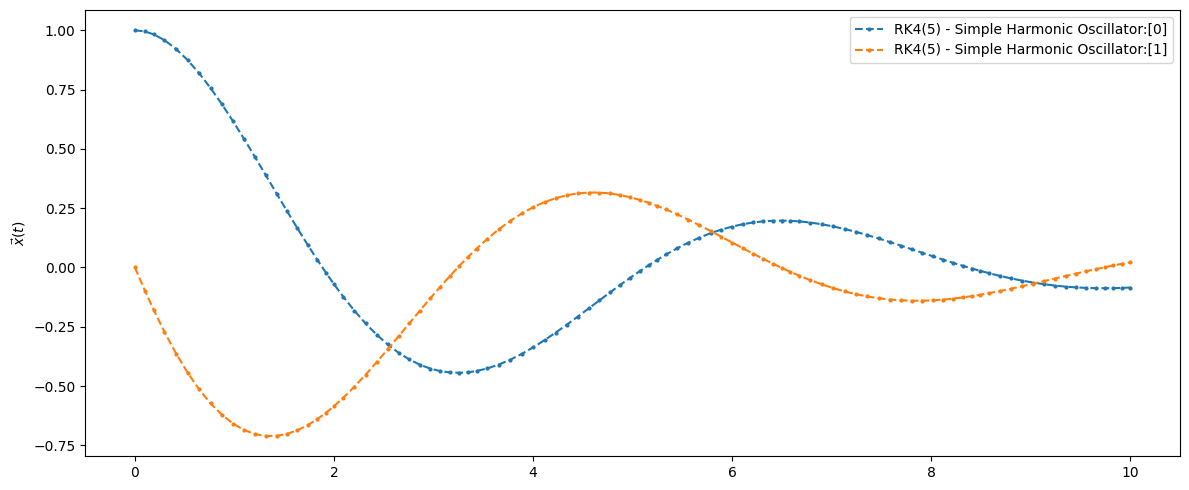

In [7]:
fig, axes = neuralode.plot.trajectory.plot_trajectory([(i, j) for i, j in zip(sha_states, sha_times)], method_label="RK4(5) - Simple Harmonic Oscillator")

The Jacobian is the matrix of gradients of each output with respect to each input. For given vector function $\vec{f}(\vec{x})$, the Jacobian is:

$$
J = 
\begin{bmatrix}
\frac{\partial{f_1}}{\partial{x_1}} & \cdots & \frac{\partial{f_1}}{\partial{x_n}} \\
& \vdots & \\
\frac{\partial{f_m}}{\partial{x_1}} & \cdots & \frac{\partial{f_m}}{\partial{x_n}} \\
\end{bmatrix}
$$

where $\frac{\partial{f_m}}{\partial{x_n}}$ is the (partial) derivative of the $m^{th}$ component of $\vec{f}$ with respect to the $n^{th}$ component of $\vec{x}$. What this matrix tells us how $\vec{f}$ when $\vec{x}$ changes. 
 
If we think of our integration as a function $\vec{f}$, the Jacobian indicates how the result of our integration changes with respect to the inputs. We can compute it by creating a function that simply returns our trajectory and then using the `pytorch.autograd` functional API as follows.

In [8]:
def compute_trajectory_return_final_state(x, t0, t1, f, d):
    return adaptive_rk45_integrator.apply(neuralode.dynamics.simple_harmonic_oscillator, x, t0, t1, initial_timestep, {'atol': atol, 'rtol': rtol*1e-3}, f, d)[0][0]

def compute_trajectory_return_intermediate_state(x, t0, t1, f, d):
    return adaptive_rk45_integrator.apply(neuralode.dynamics.simple_harmonic_oscillator, x, t0, t1, initial_timestep, {'atol': atol, 'rtol': rtol*1e-3}, f, d)[2][3][0]

test_variables = [initial_state.clone(), initial_time.clone(), final_time.clone(), frequency.clone(), damping.clone()]
test_variables = [i.detach().clone().requires_grad_(True) for i in test_variables]

jac_wrt_initial_state, jac_wrt_initial_time, jac_wrt_final_time, jac_wrt_freq, jac_wrt_damp = torch.autograd.functional.jacobian(compute_trajectory_return_final_state, tuple(test_variables))
print(f"The Jacobian of x(t1) wrt. x(t0) is: {jac_wrt_initial_state.cpu().numpy()}")
print(f"The Jacobian of x(t1) wrt. t0 is: {jac_wrt_initial_time.cpu().numpy()}")
print(f"The Jacobian of x(t1) wrt. t1 is: {jac_wrt_final_time.cpu().numpy()}")
print(f"The Jacobian of x(t1) wrt. frequency is: {jac_wrt_freq.cpu().numpy()}")
print(f"The Jacobian of x(t1) wrt. damping is: {jac_wrt_damp.cpu().numpy()}")

jac_wrt_initial_state, jac_wrt_initial_time, jac_wrt_final_time, jac_wrt_freq, jac_wrt_damp = torch.autograd.functional.jacobian(compute_trajectory_return_intermediate_state, tuple(test_variables))
print()
print(f"The Jacobian of x({sha_times[3].item():.4e}) wrt. x(t0) is: {jac_wrt_initial_state.cpu().numpy()}")
print(f"The Jacobian of x({sha_times[3].item():.4e}) wrt. t0 is: {jac_wrt_initial_time.cpu().numpy()}")
print(f"The Jacobian of x({sha_times[3].item():.4e}) wrt. t1 is: {jac_wrt_final_time.cpu().numpy()}")
print(f"The Jacobian of x({sha_times[3].item():.4e}) wrt. frequency is: {jac_wrt_freq.cpu().numpy()}")
print(f"The Jacobian of x({sha_times[3].item():.4e}) wrt. damping is: {jac_wrt_damp.cpu().numpy()}")

The Jacobian of x(t1) wrt. x(t0) is: [-0.08477596 -0.02160443]
The Jacobian of x(t1) wrt. t0 is: -0.021604426103042366
The Jacobian of x(t1) wrt. t1 is: 0.021604426126233627
The Jacobian of x(t1) wrt. frequency is: 0.2160442607119664
The Jacobian of x(t1) wrt. damping is: 0.823620406656798

The Jacobian of x(2.9702e-01) wrt. x(t0) is: [0.9986817  0.05089237]
The Jacobian of x(2.9702e-01) wrt. t0 is: 0.05089236517502573
The Jacobian of x(2.9702e-01) wrt. t1 is: 0.0
The Jacobian of x(2.9702e-01) wrt. frequency is: -0.0026247345057088646
The Jacobian of x(2.9702e-01) wrt. damping is: 4.513039652480764e-05


We can further use the `torch.autograd.gradcheck` function to test that these Jacobians are correct. The basic overview of `gradcheck` is that it computes the gradient using finite differences^[1] and then compares them to our implementation of the gradient. Within some numerical tolerance, these should be identical and this function can test this. We can also test that the gradient of the gradient is correct by using a similar procedure and the `torch.autograd.gradgradcheck` function.

The three cases we need to test are if the initial state, the final state and an arbitrarily selected intermediate state are correctly differentiated. We also need to test these with tighter tolerances than our previous integration as we need to minimise the error accumulated during both the forward _and_ the backward integration.


[[1] - Finite Difference on Wikipedia](https://en.wikipedia.org/wiki/Finite_difference)

In [9]:
def test_func_adaptive(init_state, integration_t0, integration_t1, freq, damp):
    # Integrates the system with tighter tolerances
    res = adaptive_rk45_integrator.apply(neuralode.dynamics.simple_harmonic_oscillator, init_state, integration_t0, integration_t1, initial_timestep.double()*1e-2, {'atol': atol.double(), 'rtol': rtol.double()*1e-3}, freq, damp)
    return res

def test_func_initial_state(init_state, integration_t0, integration_t1, freq, damp):
    # Integrates the system and returns the initial state stored in the intermediate states
    res = test_func_adaptive(init_state, integration_t0, integration_t1, freq, damp)
    return res[2][0]

def test_func_intermediate_state(init_state, integration_t0, _, freq, damp):
    # Ideally we'd pick from the intermediate states tensor, but during finite differencing 
    # the time values may change and as a result we will sample the wrong point in the trajectory.
    # The solution to this is to treat the system as being integrated to some intermediate time and return
    # the final state.
    res = test_func_adaptive(init_state, integration_t0, sha_times[sha_times.shape[0]//2], freq, damp)
    return res[0]
    
def test_func_final_state(init_state, integration_t0, integration_t1, freq, damp):
    # Return the final state of the integration
    res = test_func_adaptive(init_state, integration_t0, integration_t1, freq, damp)
    return res[0]

In [10]:
from torch.autograd import gradcheck

test_variables = [initial_state, initial_time, initial_time.detach().clone()+0.1, frequency, damping]
# 64-bit floats are required for correct evaluation of finite differences and derivatives
test_variables = [i.double() for i in test_variables]
test_functions = [test_func_final_state, test_func_initial_state, test_func_intermediate_state]

def generate_test_vars():
    # Randomly generate difference integration conditions
    test_t0 = (torch.rand_like(initial_time.double()) - 1.0)*0.1
    test_t1 = torch.rand_like(initial_time.double())*0.1 + test_t0.detach()
    test_x = 2*torch.rand_like(initial_state.double()) - 1.0
    test_frequency = torch.rand_like(frequency.double())
    test_damping = torch.rand_like(damping.double())
    return [i.requires_grad_(True) for i in [test_x, test_t0, test_t1, test_frequency, test_damping]]

num_tests = 16

# Run test on our initial conditions defined earlier
print(f"[0/{num_tests}] - vars: {[i.detach().cpu().numpy() for i in test_variables]}, success_jacobian: [", end='')
for fn in test_functions:
    print(gradcheck(fn, [i.detach().clone().requires_grad_(True) for i in test_variables]), end=', ' if fn != test_functions[-1] else '')
print(']')
      
# Run test on the randomly generated states
for iter_idx in range(num_tests):
    variables = generate_test_vars()
    print(f"[{iter_idx+1}/{num_tests}] - vars: {[i.detach().cpu().numpy() for i in variables]}, success: [", end='')
    for fn in test_functions:
        print(gradcheck(fn, variables), end=', ' if fn != test_functions[-1] else '')
    print(']')

[0/16] - vars: [array([1., 0.]), array(0.), array(0.1), array(1.), array(0.25)], success_jacobian: [True, True, True]
[1/16] - vars: [array([-0.53149497, -0.64580155]), array(-0.09389467), array(-0.07143922), array(0.55606806), array(0.10944385)], success: [True, True, True]
[2/16] - vars: [array([ 0.15955251, -0.00666538]), array(-0.05390871), array(0.01692782), array(0.51037517), array(0.32953764)], success: [True, True, True]
[3/16] - vars: [array([-0.8204064 , -0.76508816]), array(-0.02817939), array(0.01027172), array(0.64023946), array(0.19676658)], success: [True, True, True]
[4/16] - vars: [array([0.84974453, 0.999399  ]), array(-0.04875527), array(0.02242855), array(0.89273028), array(0.87671972)], success: [True, True, True]
[5/16] - vars: [array([-0.65892713,  0.96839645]), array(-0.01550284), array(-5.80456654e-05), array(0.81270555), array(0.43584903)], success: [True, True, True]
[6/16] - vars: [array([0.51552335, 0.84502525]), array(-0.05856788), array(-0.01572713), arra

In [11]:
# Generate reference trajectory for optimisation/learning
with torch.no_grad():
    _, _, sha_states_ref, sha_times_ref, _ = adaptive_rk45_integrator.apply(neuralode.dynamics.simple_harmonic_oscillator, initial_state, initial_time, final_time, initial_timestep, integrator_kwargs, frequency, damping)
sha_states_ref, sha_times_ref = sha_states_ref.detach(), sha_times_ref.detach()

In [12]:
state_dataset = sha_states_ref[1:].clone()
time_dataset  = sha_times_ref[1:].clone()

# Next, we'll define a closure function whose sole purpose is to
# zero the gradients and compute the error. This is useful as it allows switching to other
# optimizers such as LBFGS or anything that re-evaluates the error without
# computing its gradient
def sha_closure(rhs: neuralode.integrators.signatures.integration_fn_signature, parameters: list[torch.Tensor], minibatch: dict[str, torch.Tensor]) -> torch.Tensor:
    """
    Computes the error on a minibatch of states and times according to the given function `rhs` and its parameters.
    :param rhs: The function to integrate
    :param parameters: The parameters wrt. which the gradients should be computed
    :param minibatch: The minibatch to compute the error on
    :return: The error of the integration on the minibatch
    """
    current_state = initial_state.detach().clone()
    current_time  = initial_time.detach().clone()
    optimiser.zero_grad()
    error = 0.0
    
    times = minibatch['times']
    states = minibatch['states']
    
    # We need to sort both times and states simultaneously, so we'll use `argsort`
    sorted_time_indices = torch.argsort(times)
    times, states = times[sorted_time_indices], states[sorted_time_indices]
    
    for sample_state, sample_time in zip(states, times):
        dt = torch.minimum(initial_timestep, sample_time - current_time).detach()
        current_state, current_time, _, _, _ = adaptive_rk45_integrator.apply(rhs, current_state, current_time, sample_time, dt, integrator_kwargs, *parameters)
        error = error + torch.linalg.norm(sample_state - current_state)/times.shape[0]
    if error.requires_grad:
        error.backward()
    return error

# We need to set the size of our mini-batches
batch_size = 4

# Now we need an optimisation `loop` where we will take steps to minimise the error
number_of_gd_steps = 128

In [13]:
# We reinitialise our variables
optimised_frequency = torch.tensor(0.1, requires_grad=True)
optimised_damping = torch.tensor(1.0, requires_grad=True)
# As damping needs to be a strictly positive quantity, we log-encode it
log_encoded_damping = torch.log(optimised_damping.detach()).requires_grad_(True)

# First, we'll create an `optimiser` following pytorch convention
optimiser = torch.optim.Adam([optimised_frequency, log_encoded_damping], lr=1e-1, amsgrad=True)
# Whenever the loss plateaus, we can reduce the learning rate to improve convergence
lr_on_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser)

# We also need to track the best solution thus far
best_error = torch.inf
best_frequency, best_damping = optimised_frequency.detach().clone(), optimised_damping.detach().clone()
for step in range(number_of_gd_steps):
    epoch_error = 0.0
    shuffled_indices = torch.randperm(time_dataset.shape[0])
    for batch_idx in range(0, time_dataset.shape[0], batch_size):
        batch_dict = {
            'times': time_dataset[shuffled_indices][batch_idx:batch_idx+batch_size],
            'states': state_dataset[shuffled_indices][batch_idx:batch_idx+batch_size],
        }
    
        step_error = optimiser.step(lambda: sha_closure(neuralode.dynamics.simple_harmonic_oscillator, [optimised_frequency, torch.exp(log_encoded_damping)], batch_dict))
        epoch_error = epoch_error + step_error.item()*batch_dict['times'].shape[0]
        print(f"[{step+1}/{number_of_gd_steps}]/[{batch_idx}/{time_dataset.shape[0]}] Batch Error: {step_error:.6f}, Current Frequency: {optimised_frequency.item():.4f}, Current Damping: {torch.exp(log_encoded_damping).item():.4f}", end='\r')
    epoch_error = epoch_error/time_dataset.shape[0]
    if epoch_error < best_error:
        best_error = epoch_error
        best_frequency = optimised_frequency.detach().clone()
        best_damping = torch.exp(log_encoded_damping.detach().clone())
    lr_on_plateau.step(epoch_error)
    print(" "*128, end="\r")
    print(f"[{step+1}/{number_of_gd_steps} - lr: {lr_on_plateau.get_last_lr()[0]:.4e}] Epoch Error: {epoch_error:.6f}, Current Frequency: {optimised_frequency.item():.6f}, Current Damping: {torch.exp(log_encoded_damping).item():.6f}")
    # If the step size is too small, then we can interrupt the
    # training as it will not lead to significant improvements
    if lr_on_plateau.get_last_lr()[0] < 1e-6:
        break

rel_err = torch.mean(torch.abs(1 - best_frequency / frequency)).item()
mae_err = torch.mean(torch.abs(frequency - best_frequency)).item()
print(f"Best frequency: {best_frequency.item():.6f}, relative error: {rel_err:.6%}, mean absolute error: {mae_err:.6f}")
rel_err = torch.mean(torch.abs(1 - best_damping / damping)).item()
mae_err = torch.mean(torch.abs(damping - best_damping)).item()
print(f"Best damping:   {best_damping.item():.6f}, relative error: {rel_err:.6%}, mean absolute error: {mae_err:.6f}")

[1/128 - lr: 1.0000e-01] Epoch Error: 0.321610, Current Frequency: 1.251675, Current Damping: 0.337432                          
[2/128 - lr: 1.0000e-01] Epoch Error: 0.077131, Current Frequency: 0.995374, Current Damping: 0.271970                          
[3/128 - lr: 1.0000e-01] Epoch Error: 0.012469, Current Frequency: 1.007481, Current Damping: 0.247264                          
[4/128 - lr: 1.0000e-01] Epoch Error: 0.010313, Current Frequency: 0.993685, Current Damping: 0.251497                          
[5/128 - lr: 1.0000e-01] Epoch Error: 0.015036, Current Frequency: 0.987936, Current Damping: 0.255128                          
[6/128 - lr: 1.0000e-01] Epoch Error: 0.015201, Current Frequency: 0.992519, Current Damping: 0.247674                          
[7/128 - lr: 1.0000e-01] Epoch Error: 0.014721, Current Frequency: 1.003300, Current Damping: 0.246292                          
[8/128 - lr: 1.0000e-01] Epoch Error: 0.010783, Current Frequency: 1.003838, Current Damping: 0.2

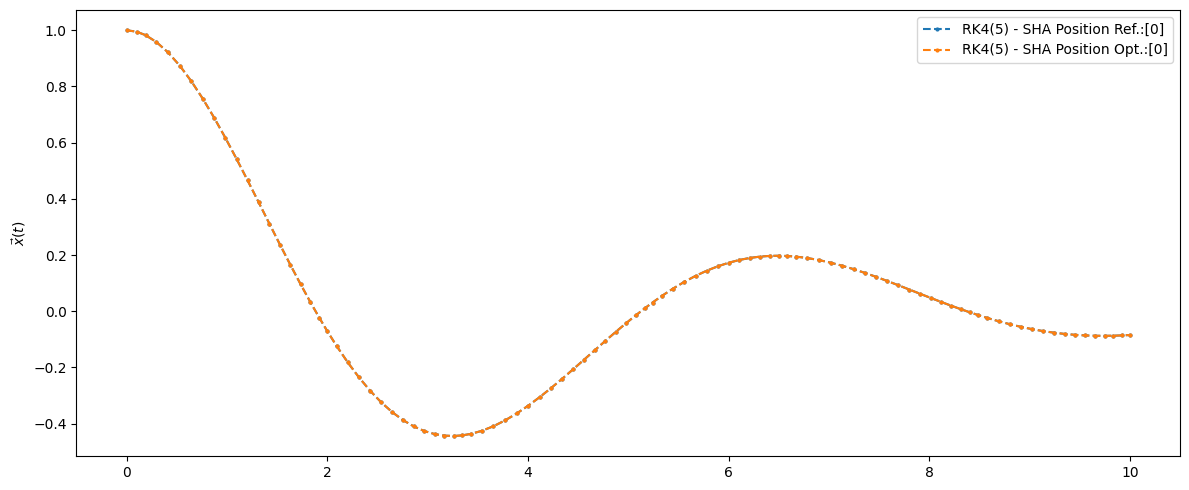

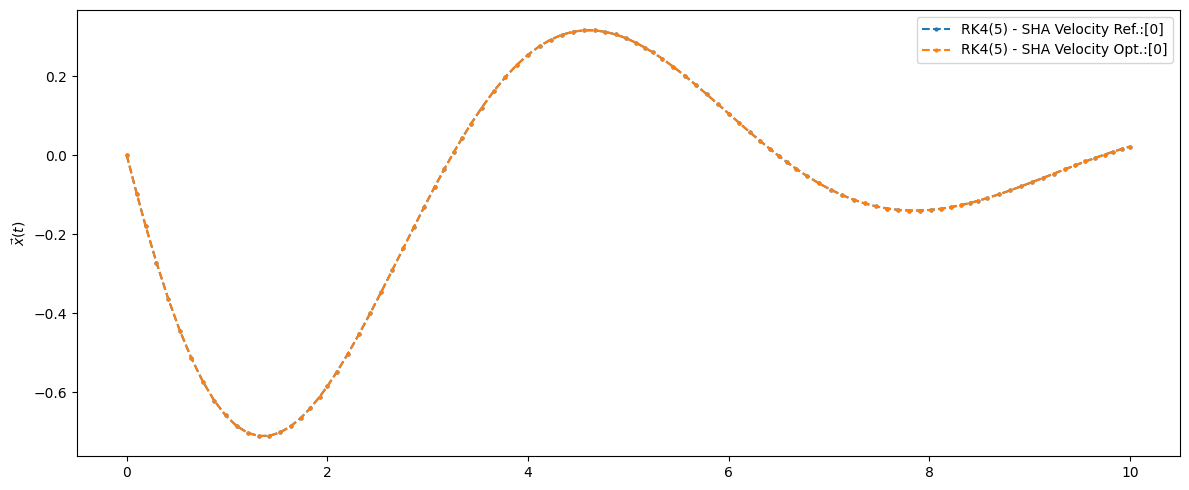

In [14]:
fig_ref_position, axes_ref_position = neuralode.plot.trajectory.plot_trajectory([(i[0], j) for i, j in zip(sha_states_ref, sha_times_ref)], method_label="RK4(5) - SHA Position Ref.")
fig_ref_velocity, axes_ref_velocity = neuralode.plot.trajectory.plot_trajectory([(i[1], j) for i, j in zip(sha_states_ref, sha_times_ref)], method_label="RK4(5) - SHA Velocity Ref.")

_, _, sha_states_optimised, sha_times_optimised, _ = adaptive_rk45_integrator.apply(neuralode.dynamics.simple_harmonic_oscillator, initial_state, initial_time, final_time, initial_timestep, integrator_kwargs, best_frequency, best_damping)
_ = neuralode.plot.trajectory.plot_trajectory([(i[0], j) for i, j in zip(sha_states_optimised, sha_times_optimised)], axes=axes_ref_position, method_label="RK4(5) - SHA Position Opt.")
_ = neuralode.plot.trajectory.plot_trajectory([(i[1], j) for i, j in zip(sha_states_optimised, sha_times_optimised)], axes=axes_ref_velocity, method_label="RK4(5) - SHA Velocity Opt.")

This replicates the prior results and actually improves on them by a small margin.

Now let's add a neural network into the mix! This will be the simplest network possible aka a matrix multiplied with the input vector. While this may seem simple, you'll see that our simple harmonic oscillator can also be expressed as a matrix multiplied by the input. It has a very specific structure that arises from the fact that it was a second order equation. I've written this matrix below:

$$
\begin{bmatrix}
    x^{(1)} \\
    v^{(1)}
\end{bmatrix} = 
\mathbf{A}
\begin{bmatrix}
    x \\
    v
\end{bmatrix}
$$

where

$$
\mathbf{A} =
\begin{bmatrix}
    0 & 1 \\
    -\omega^2 & -2\zeta\omega
\end{bmatrix}
$$

Given that matrix multiplication underlies most neural networks, we can try to learn this $\mathbf{A}$-matrix and at the same time introduce some of the Neural Network machinery in PyTorch. We will revisit these later when learning more interesting/complex systems.

In [15]:
# we define our network as a subclass of torch.nn.Module
# This allows PyTorch to appropriately track parameters
class OscillatorNet(torch.nn.Module):
    def __init__(self):
        # First we initialise the superclass, `torch.nn.Module`
        super().__init__()
        # Then we define the actual neural network
        # Most Neural Networks operate sequentially so they can be wrapped
        # inside a torch.nn.Sequential which takes each layer
        # as an argument.
        # Since we're only learning one matrix, we have
        # one layer, the `torch.nn.Linear`.
        # `torch.nn.Linear` stores a matrix and a bias which actually makes it
        # an Affine transformation rather than a purely linear transformation
        self.internal_net = torch.nn.Sequential(
            torch.nn.Linear(2, 2),
        )
    
    def forward(self, x, t):
        # Our network only depends on x, but since it could also depend on t, we have
        # included it for completeness
        # Additionally, PyTorch layers and modules expect a batched tensor
        # ie. a tensor where the first dimension is over different samples
        # Since we don't depend on batches, we check if the input is 1-dimensional
        # And add a batch dimension as needed for the internal module
        if x.dim() == 1:
            return self.internal_net(x[None])[0]
        else:
            return self.internal_net(x)

# And then instantiate the weights of the network itself
def init_weights(m):
    # For each layer type, we can define how we initialise its values
    if isinstance(m, torch.nn.Linear):
        # A linear equation with a positive coefficient
        # translates to exponential growth and a negative coefficient
        # to exponential decay. In order to preserve stability we sample a matrix
        # that is biased to be negative in its entries thus ensuring
        # that our initial system is of exponential decay.
        m.weight.data.normal_(0.0, 0.1)
        if m.bias is not None:
            m.bias.data.normal_(0.0, 0.1)

In [16]:
# Here we instantiate our network.
torch.manual_seed(36)
simple_oscillator_net = OscillatorNet()
simple_oscillator_net.apply(init_weights)

# `torch.autograd.Function`s track computation on all input tensors.
# For that reason, we must pass our neural network parameters to the integrator,
# which will pass it to the derivative function.
# Since our network is stateful, we don't use these parameters, but define them in 
# the function signature.
def sha_nn_fn(x, t, *nn_parameters):
    return torch.func.functional_call(simple_oscillator_net, {k: p for (k, _), p in zip(simple_oscillator_net.named_parameters(), nn_parameters)}, (x, t))

optimiser = torch.optim.Adam(simple_oscillator_net.parameters(), lr=1e-3, amsgrad=True)
# OneCycleLR cycles the learning rate from max_lr/25 to max_lr and then back down.
# This helps the network escape local minima and find better solutions.
# It is an alternative to ReduceLROnPlateau which can sometimes get stuck in local minima
# for problems with a small number of degrees of freedom.
one_cycle_lr = torch.optim.lr_scheduler.OneCycleLR(optimiser, max_lr=1e-1, steps_per_epoch=round(time_dataset.shape[0]/batch_size+0.5), epochs=number_of_gd_steps, three_phase=True)

ideal_matrix = neuralode.dynamics.get_simple_harmonic_oscillator_matrix(frequency, damping)
ideal_bias = torch.zeros_like(initial_state)

best_error = torch.inf
# For pytorch modules, the `state_dict` method allows us to get a copy
# of all the parameters that define the model, thus enabling us to 
# store the state as well as restore it.
best_parameters = simple_oscillator_net.state_dict()
for step in range(number_of_gd_steps):
    epoch_error = 0.0
    shuffled_indices = torch.randperm(time_dataset.shape[0])
    for batch_idx in range(0, time_dataset.shape[0], batch_size):
        batch_dict = {
            'times': time_dataset[shuffled_indices][batch_idx:batch_idx+batch_size],
            'states': state_dataset[shuffled_indices][batch_idx:batch_idx+batch_size],
        }
    
        step_error = optimiser.step(lambda: sha_closure(sha_nn_fn, list(simple_oscillator_net.parameters()), batch_dict))
        epoch_error = epoch_error + step_error.item()*batch_dict['times'].shape[0]
        one_cycle_lr.step()
        # print(f"[{step+1}/{number_of_gd_steps}]/[{batch_idx}/{time_dataset.shape[0]}] Batch Error: {step_error:.6f} ", end='\r')
    epoch_error = epoch_error/time_dataset.shape[0]
    if epoch_error < best_error:
        best_error = epoch_error
        best_parameters = simple_oscillator_net.state_dict()
    learned_matrix = simple_oscillator_net.state_dict()['internal_net.0.weight']
    learned_bias = simple_oscillator_net.state_dict()['internal_net.0.bias']
    # Ideally our matrix is equivalent to our simple harmonic oscillator matrix and our bias goes to zero
    print(f"[{step+1}/{number_of_gd_steps} - lr: {one_cycle_lr.get_last_lr()[0]:.4e}] Epoch Error: {epoch_error:.6f}, \nW={learned_matrix.cpu()}, \nb={learned_bias.cpu()}")
    print()
    
simple_oscillator_net.load_state_dict(best_parameters)
learned_matrix = simple_oscillator_net.state_dict()['internal_net.0.weight']
learned_bias = simple_oscillator_net.state_dict()['internal_net.0.bias']

# Before we were looking at relative error, but in the case of a matrix with zeros,
# the relative error is undefined, so we look at another common metric: mean absolute error
print(f"Best matrix: {learned_matrix}, mean absolute error: {torch.mean(torch.abs(ideal_matrix - learned_matrix)).item():.6f}")
print(f"Best bias:   {learned_bias}, mean absolute error: {torch.mean(torch.abs(ideal_bias - learned_bias)).item():.6f}")

[1/128 - lr: 4.1609e-03] Epoch Error: 1.609792, 
W=tensor([[ 0.0641,  0.1550],
        [-0.0738, -0.1089]]), 
b=tensor([-0.0626, -0.0914])

[2/128 - lr: 4.6425e-03] Epoch Error: 0.720409, 
W=tensor([[ 0.0104,  0.2160],
        [-0.0536, -0.1961]]), 
b=tensor([-0.1232, -0.0374])

[3/128 - lr: 5.4416e-03] Epoch Error: 0.504084, 
W=tensor([[-0.0127,  0.2244],
        [-0.0064, -0.2662]]), 
b=tensor([-0.1308,  0.0365])

[4/128 - lr: 6.5528e-03] Epoch Error: 0.483388, 
W=tensor([[-0.0308,  0.2290],
        [-0.0187, -0.3025]]), 
b=tensor([-0.1357,  0.0223])

[5/128 - lr: 7.9688e-03] Epoch Error: 0.471892, 
W=tensor([[-0.0409,  0.2373],
        [-0.0125, -0.3169]]), 
b=tensor([-0.1141,  0.0231])

[6/128 - lr: 9.6799e-03] Epoch Error: 0.457693, 
W=tensor([[-0.0528,  0.2441],
        [-0.0243, -0.3263]]), 
b=tensor([-0.0928, -0.0056])

[7/128 - lr: 1.1675e-02] Epoch Error: 0.451436, 
W=tensor([[-0.0744,  0.2438],
        [-0.0301, -0.3349]]), 
b=tensor([-0.0837, -0.0036])

[8/128 - lr: 1.3940e

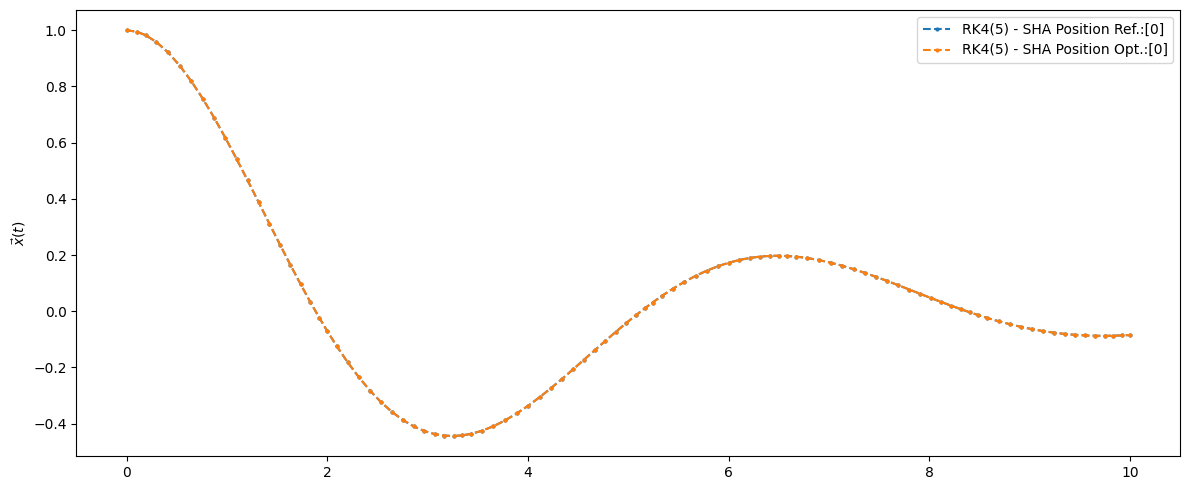

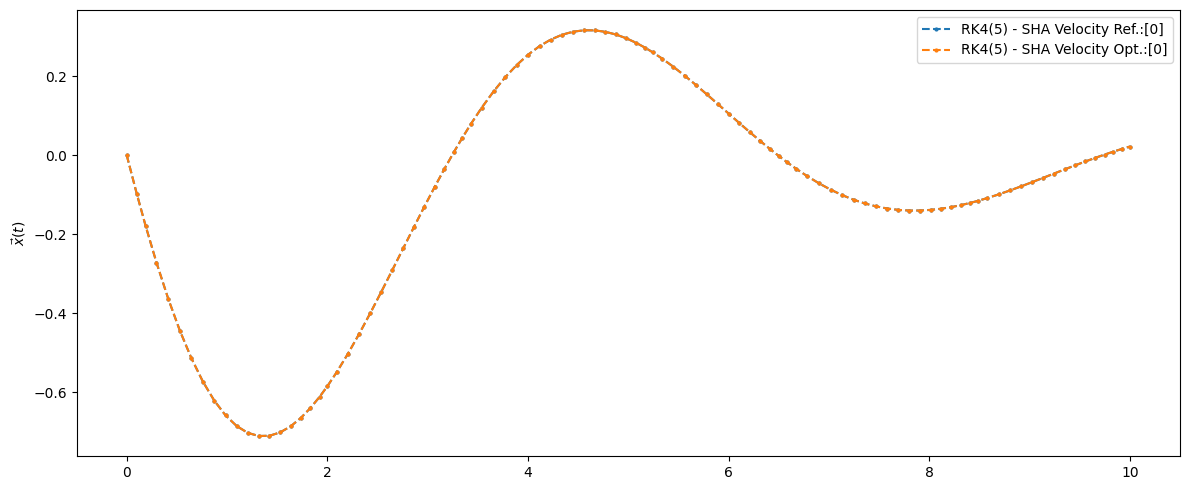

In [17]:
fig_ref_position, axes_ref_position = neuralode.plot.trajectory.plot_trajectory([(i[0], j) for i, j in zip(sha_states_ref, sha_times_ref)], method_label="RK4(5) - SHA Position Ref.")
fig_ref_velocity, axes_ref_velocity = neuralode.plot.trajectory.plot_trajectory([(i[1], j) for i, j in zip(sha_states_ref, sha_times_ref)], method_label="RK4(5) - SHA Velocity Ref.")

simple_oscillator_net.load_state_dict(best_parameters)
_, _, sha_states_optimised, sha_times_optimised, _ = adaptive_rk45_integrator.apply(sha_nn_fn, initial_state, initial_time, final_time, initial_timestep, integrator_kwargs)
_ = neuralode.plot.trajectory.plot_trajectory([(i[0], j) for i, j in zip(sha_states_optimised, sha_times_optimised)], axes=axes_ref_position, method_label="RK4(5) - SHA Position Opt.")
_ = neuralode.plot.trajectory.plot_trajectory([(i[1], j) for i, j in zip(sha_states_optimised, sha_times_optimised)], axes=axes_ref_velocity, method_label="RK4(5) - SHA Velocity Opt.")

And we can see that the neural network is able to effectively learn the dynamics of this system, but it would not extend to other systems with different frequency and damping as they would have a different matrix.

In the coming notebooks, we will extend our network to learn the general dynamics by passing frequency and damping as a parameter. Further, we will learn more complex system dynamics and how to manipulate these systems.